In [1]:
import os
import sys
from dotenv import load_dotenv
from pathlib import Path
import json
from IPython.display import Markdown, Image


# Añadimos el directorio raíz del proyecto al path
try:
    # Para scripts .py
    current_file = Path(__file__).resolve()
    project_root = current_file.parent.parent  # Ajusta si tu estructura cambia
except NameError:
    # Para notebooks
    current_file = Path().resolve()
    project_root = current_file.parent  # Ajusta según donde esté tu notebook

# Añadir al sys.path si no está ya
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))


from src.utils.graphics import create_dashboard_from_json
from src.back.graphs import (
    BusinessLogicRetrievalGraph,
    ChunkProcessingGraph,
    ContextGeneratorGraph,
    get_conclusions_generator_graph,
    get_query_generator_graph,
    get_query_validator_graph,
    get_main_graph,
    MdlRetrievalGraph,
)

---

## CONCLUSIONS GENERATOR

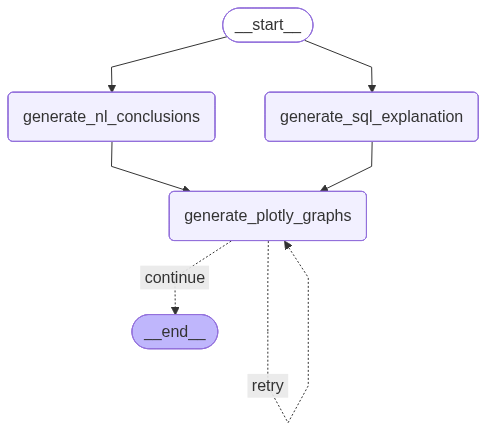

In [2]:
conclusions_generator_graph = get_conclusions_generator_graph()
Image(conclusions_generator_graph.get_graph().draw_mermaid_png())

In [3]:
user_query = 'Muéstrame los 10 productos más vendidos para el B2B en el último trimestre, excluyendo los Accesorios. Mes a mes indica cuántas unidades se vendieron, y muestra también a qué categoría y subcategoría pertenecen'

query_results = [{'producto': 'Camiseta clásica, P', 'categoria': 'Prenda', 'subcategoria': 'Camiseta', 'primer_mes': 381, 'segundo_mes': 380, 'tercer_mes': 190, 'total': 951},
  {'producto': 'Jersey clásico de manga corta, SG', 'categoria': 'Prenda', 'subcategoria': 'Jersey', 'primer_mes': 329, 'segundo_mes': 299, 'tercer_mes': 183, 'total': 811},
  {'producto': "Women's Mountain Shorts, S", 'categoria': 'Prenda', 'subcategoria': 'Pantalones cortos', 'primer_mes': 295, 'segundo_mes': 258, 'tercer_mes': 141, 'total': 694},
  {'producto': 'Jersey con logotipo de manga larga, G', 'categoria': 'Prenda', 'subcategoria': 'Jersey', 'primer_mes': 312, 'segundo_mes': 243, 'tercer_mes': 129, 'total': 684},
  {'producto': 'AWC Logo Cap', 'categoria': 'Prenda', 'subcategoria': 'Gorra', 'primer_mes': 291, 'segundo_mes': 243, 'tercer_mes': 121, 'total': 655},
  {'producto': "Women's Mountain Shorts, L", 'categoria': 'Prenda', 'subcategoria': 'Pantalones cortos', 'primer_mes': 262, 'segundo_mes': 236, 'tercer_mes': 120, 'total': 618},
  {'producto': 'Jersey clásico de manga corta, G', 'categoria': 'Prenda', 'subcategoria': 'Jersey', 'primer_mes': 217, 'segundo_mes': 231, 'tercer_mes': 113, 'total': 561},
  {'producto': 'Calcetines para carreras, G', 'categoria': 'Prenda', 'subcategoria': 'Calcetines', 'primer_mes': 231, 'segundo_mes': 179, 'tercer_mes': 93, 'total': 503},
  {'producto': 'Camiseta clásica, M', 'categoria': 'Prenda', 'subcategoria': 'Camiseta', 'primer_mes': 197, 'segundo_mes': 187, 'tercer_mes': 85, 'total': 469},
  {'producto': 'Half-Finger Gloves, M', 'categoria': 'Prenda', 'subcategoria': 'Guantes', 'primer_mes': 187, 'segundo_mes': 168, 'tercer_mes': 82, 'total': 437}]

sql_query = "WITH \nlast_quarter AS (\n  SELECT\n    fs.product_key,\n    COALESCE(dp.spanish_product_name, dp.english_product_name) AS product_name,\n    dp.spanish_product_category_name,\n    dp.spanish_product_subcategory_name,\n    EXTRACT(MONTH FROM fs.order_date) AS month_in_quarter,\n    fs.order_quantity\n  FROM\n    sales.fact_sales fs\n    JOIN sales.dim_product dp ON fs.product_key = dp.product_key\n  WHERE\n    fs.sale_source = 'reseller_sales'\n    AND dp.spanish_product_category_name <> 'Accesorio'\n    AND fs.order_date >= date_trunc('quarter', CURRENT_DATE - interval '3 months')\n    AND fs.order_date < date_trunc('quarter', CURRENT_DATE)\n),\ntop_products AS (\n  SELECT\n    product_key,\n    product_name,\n    spanish_product_category_name,\n    spanish_product_subcategory_name,\n    SUM(order_quantity) AS total_qty\n  FROM\n    last_quarter\n  GROUP BY\n    product_key, product_name, spanish_product_category_name, spanish_product_subcategory_name\n  ORDER BY\n    total_qty DESC\n  LIMIT 10\n)\nSELECT\n  tp.product_name AS producto,\n  tp.spanish_product_category_name AS categoria,\n  tp.spanish_product_subcategory_name AS subcategoria,\n  SUM(lq.order_quantity) FILTER (WHERE lq.month_in_quarter = EXTRACT(MONTH FROM date_trunc('quarter', CURRENT_DATE - interval '3 months'))) AS primer_mes,\n  SUM(lq.order_quantity) FILTER (WHERE lq.month_in_quarter = EXTRACT(MONTH FROM date_trunc('quarter', CURRENT_DATE - interval '3 months') + interval '1 month')) AS segundo_mes,\n  SUM(lq.order_quantity) FILTER (WHERE lq.month_in_quarter = EXTRACT(MONTH FROM date_trunc('quarter', CURRENT_DATE - interval '3 months') + interval '2 month')) AS tercer_mes,\n  SUM(lq.order_quantity) AS total\nFROM\n  top_products tp\n  LEFT JOIN last_quarter lq ON tp.product_key = lq.product_key\nGROUP BY\n  tp.product_name, tp.spanish_product_category_name, tp.spanish_product_subcategory_name\nORDER BY\n  total DESC;"

results = conclusions_generator_graph.invoke({
    'user_query': user_query,
    'language': 'Spanish',
    'sql_query': sql_query,
    'query_results': query_results,
})

results


--- INICIANDO GENERACIÓN DE CONCLUSIONES 📝 ---

--- INICIANDO EXPLICACIÓN DE CONSULTA SQL 🗂️ ---

--- INICIANDO GENERACIÓN DE GRÁFICOS 📊 ---


{'nl_output': '1. Las prendas dominan las ventas B2B en el último trimestre, con todas las posiciones en el top 10 perteneciendo a esta categoría.  \n2. La subcategoría "Camiseta" lidera en unidades vendidas, destacando la "Camiseta clásica, P" con 951 unidades totales.  \n3. Los jerseys, tanto de manga corta como larga, son productos clave, sumando tres posiciones en el ranking.  \n4. Los pantalones cortos femeninos ("Women\'s Mountain Shorts") aparecen en dos tallas (S y L) dentro del top 10.  \n5. La venta mensual muestra una tendencia decreciente en unidades vendidas de mes a mes para todos los productos listados.  \n6. La gorra "AWC Logo Cap" es el único accesorio que aparece, pero está clasificada como prenda, confirmando la exclusión de accesorios.  \n7. Los calcetines y guantes también forman parte del top 10, indicando diversidad dentro de la categoría prenda.  \n8. El producto con menor volumen en el top 10 es "Half-Finger Gloves, M" con 437 unidades vendidas en total.  \n9. 

In [4]:
print(results['nl_output'])

1. Las prendas dominan las ventas B2B en el último trimestre, con todas las posiciones en el top 10 perteneciendo a esta categoría.  
2. La subcategoría "Camiseta" lidera en unidades vendidas, destacando la "Camiseta clásica, P" con 951 unidades totales.  
3. Los jerseys, tanto de manga corta como larga, son productos clave, sumando tres posiciones en el ranking.  
4. Los pantalones cortos femeninos ("Women's Mountain Shorts") aparecen en dos tallas (S y L) dentro del top 10.  
5. La venta mensual muestra una tendencia decreciente en unidades vendidas de mes a mes para todos los productos listados.  
6. La gorra "AWC Logo Cap" es el único accesorio que aparece, pero está clasificada como prenda, confirmando la exclusión de accesorios.  
7. Los calcetines y guantes también forman parte del top 10, indicando diversidad dentro de la categoría prenda.  
8. El producto con menor volumen en el top 10 es "Half-Finger Gloves, M" con 437 unidades vendidas en total.  
9. La suma total de unidade

In [5]:
print(results['sql_explanation'])

## Análisis de la Lógica de la Consulta

La consulta primero identifica las ventas del último trimestre completo, filtrando solo las realizadas a través del canal B2B (denominado aquí como "reseller_sales") y excluyendo productos de la categoría "Accesorio". Para ello, une la tabla de ventas con la tabla de productos para obtener el nombre, categoría y subcategoría de cada producto. Luego, suma la cantidad vendida de cada producto en ese periodo y selecciona los 10 productos con mayor volumen de ventas. Finalmente, para esos 10 productos, calcula la cantidad vendida en cada uno de los tres meses del trimestre, mostrando también la categoría y subcategoría a la que pertenecen.

## Conclusión y Resultados Clave

El resultado proporciona una lista clara de los 10 productos más vendidos en el canal B2B durante el último trimestre, con un desglose mensual de las unidades vendidas, lo que permite observar tendencias de venta dentro del trimestre. Además, al incluir la categoría y subcategorí

In [7]:
create_dashboard_from_json(results['graphics_json'])

---

## QUERY VALIDATOR

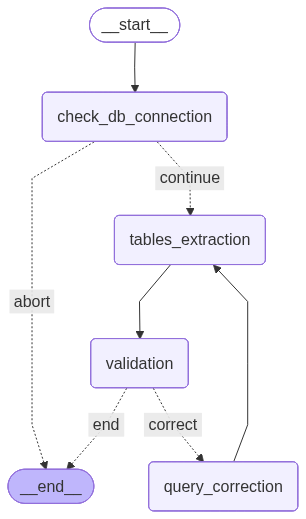

In [2]:
query_validator_graph = get_query_validator_graph()
Image(query_validator_graph.get_graph().draw_mermaid_png())

In [3]:
user_query = 'Muéstrame los 10 productos más vendidos para el B2B en el último trimestre, excluyendo los Accesorios. Mes a mes indica cuántas unidades se vendieron, y muestra también a qué categoría y subcategoría pertenecen'
sql_query = "WITH \nlast_quarter AS (\n  SELECT\n    fs.product_key,\n    COALESCE(dp.spanish_product_name, dp.english_product_name) AS product_name,\n    dp.spanish_product_category_name,\n    dp.spanish_product_subcategory_name,\n    EXTRACT(MONTH FROM fs.order_date) AS month_in_quarter,\n    fs.order_quantity\n  FROM\n    sales.ventas fs\n    JOIN sales.productos dp ON fs.product_key = dp.product_key\n  WHERE\n    fs.sale_source = 'reseller_sales'\n    AND dp.spanish_product_category_name <> 'Accesorio'\n    AND fs.order_date >= date_trunc('quarter', CURRENT_DATE - interval '3 months')\n    AND fs.order_date < date_trunc('quarter', CURRENT_DATE)\n),\ntop_products AS (\n  SELECT\n    product_key,\n    product_name,\n    spanish_product_category_name,\n    spanish_product_subcategory_name,\n    SUM(order_quantity) AS total_qty\n  FROM\n    last_quarter\n  GROUP BY\n    product_key, product_name, spanish_product_category_name, spanish_product_subcategory_name\n  ORDER BY\n    total_qty DESC\n  LIMIT 10\n)\nSELECT\n  tp.product_name AS producto,\n  tp.spanish_product_category_name AS categoria,\n  tp.spanish_product_subcategory_name AS subcategoria,\n  SUM(lq.order_quantity) FILTER (WHERE lq.month_in_quarter = EXTRACT(MONTH FROM date_trunc('quarter', CURRENT_DATE - interval '3 months'))) AS primer_mes,\n  SUM(lq.order_quantity) FILTER (WHERE lq.month_in_quarter = EXTRACT(MONTH FROM date_trunc('quarter', CURRENT_DATE - interval '3 months') + interval '1 month')) AS segundo_mes,\n  SUM(lq.order_quantity) FILTER (WHERE lq.month_in_quarter = EXTRACT(MONTH FROM date_trunc('quarter', CURRENT_DATE - interval '3 months') + interval '2 month')) AS tercer_mes,\n  SUM(lq.order_quantity) AS total\nFROM\n  top_products tp\n  LEFT JOIN last_quarter lq ON tp.product_key = lq.product_key\nGROUP BY\n  producto, categoria, subcategoria\nORDER BY\n  total DESC"
context = "### Resumen General\nEl objetivo de la consulta es identificar los 10 productos más vendidos en el modelo de negocio B2B durante el último trimestre, excluyendo aquellos clasificados como accesorios. Además, se requiere un desglose mensual de las unidades vendidas y la inclusión de información sobre la categoría y subcategoría de cada producto.\n\n### Esquema Detallado y Relaciones\n#### Base de datos y esquema\n- **Base de datos:** adventure_works_dw\n- **Esquema:** sales\n\n#### Tabla: dim_product\n- **Descripción:** Contiene información detallada de los productos vendidos.\n- **Clave primaria:** product_key\n- **Columnas relevantes:**\n  - **english_product_category_name**: VARCHAR(50), nunca NULL.\n  - **spanish_product_category_name**: VARCHAR(50), nunca NULL.\n  - **english_product_subcategory_name**: VARCHAR(50), nunca NULL.\n  - **spanish_product_subcategory_name**: VARCHAR(50), nunca NULL.\n  - **spanish_product_name**: VARCHAR(50), puede ser NULL.\n  - **english_product_name**: VARCHAR(50), nunca NULL.\n  - **finished_goods_flag**: BOOL.\n  - **start_date**: DATE.\n  - **end_date**: DATE, puede ser NULL.\n  - **dealer_price**: NUMERIC.\n  - **list_price**: NUMERIC.\n\n#### Tabla: fact_sales\n- **Descripción:** Contiene detalles de las órdenes de ventas realizadas.\n- **Clave primaria:** sales_order_number, sales_order_line_number\n- **Claves foráneas:**\n  - product_key → sales.dim_product.product_key\n- **Columnas relevantes:**\n  - **order_quantity**: INT2.\n  - **sale_source**: TEXT.\n  - **order_date**: DATE.\n  - **product_key**: Referencia a sales.dim_product.product_key.\n\n#### Relaciones entre tablas\n- Para unir las tablas **fact_sales** y **dim_product**, se utiliza la clave foránea **product_key**.\n- Condiciones de unión: `fact_sales.product_key = dim_product.product_key`.\n\n### Reglas de Negocio y Lógica\n1. **Modelo de Negocio B2B:**\n   - Las ventas B2B se identifican con el campo `sale_source` igual a `'reseller_sales'`.\n\n2. **Productos Más Vendidos:**\n   - Se define por la cantidad de unidades vendidas (`order_quantity`).\n   - Implementación SQL:\n     ```sql\n     SUM(order_quantity) AS cantidad_vendida\n     ```\n\n3. **Exclusión de Accesorios:**\n   - Se aplica el filtro `spanish_product_category_name != 'Accesorio'`.\n\n4. **Desglose Temporal:**\n   - Para calcular el último trimestre, se utiliza el campo `order_date` en la tabla `fact_sales`.\n   - Ejemplo de filtro SQL para el último trimestre:\n     ```sql\n     WHERE order_date BETWEEN DATE_TRUNC('quarter', CURRENT_DATE - INTERVAL '3 months') AND DATE_TRUNC('quarter', CURRENT_DATE) - INTERVAL '1 day';\n     ```\n   - Para el desglose mensual, se puede usar la función `EXTRACT(MONTH FROM order_date)`.\n\n5. **Categorías y Subcategorías:**\n   - Para mostrar nombres de categorías y subcategorías, se priorizan los campos en español (`spanish_product_category_name`, `spanish_product_subcategory_name`). Si son nulos, se utiliza la versión en inglés como alternativa.\n   - Ejemplo de lógica SQL:\n     ```sql\n     SELECT\n         COALESCE(spanish_product_category_name, english_product_category_name) AS producto_categoria,\n         COALESCE(spanish_product_subcategory_name, english_product_subcategory_name) AS producto_subcategoria\n     FROM sales.dim_product;\n     ```"

results = query_validator_graph.invoke({
    "user_query": user_query, 
    "sql_query": sql_query, 
    "context": context,
    "db_name": "adventure_works_dw",
    "schema_name": "sales"
})

results


--- INICIANDO COMPROBACIÓN DE CONEXIÓN A BBDD ⚙️ ---
✅ Conexión a la base de datos establecida correctamente.

--- INICIANDO FASE DE EXTRACCIÓN DE TABLAS CON LLM 🧮 ---
Tablas detectadas por el LLM: ['ventas', 'productos']

--- INICIANDO FASE DE JUEZ DE COHERENCIA 👩‍⚖️ ---

Veredicto del juez: COHERENTE ✅

--- PASANDO A FASE DE EJECUCIÓN EN POSTGRESQL ---


❌ Error de PostgreSQL detectado: table_names {'ventas'} not found in database

--- INICIANDO FASE DE CORRECIÓN 📝 ---

✅  > Query corregida recibida: WITH 
last_quarter AS (
  SELECT
    fs.product_key,
    COALESCE(dp.s...

--- INICIANDO FASE DE EXTRACCIÓN DE TABLAS CON LLM 🧮 ---
Tablas detectadas por el LLM: ['fact_sales', 'dim_product']

--- INICIANDO FASE DE JUEZ DE COHERENCIA 👩‍⚖️ ---

Veredicto del juez: COHERENTE ✅

--- PASANDO A FASE DE EJECUCIÓN EN POSTGRESQL ---


✅ Query ejecutada correctamente.


{'sql_query': "WITH \nlast_quarter AS (\n  SELECT\n    fs.product_key,\n    COALESCE(dp.spanish_product_name, dp.english_product_name) AS product_name,\n    dp.spanish_product_category_name,\n    dp.spanish_product_subcategory_name,\n    EXTRACT(MONTH FROM fs.order_date) AS month_in_quarter,\n    fs.order_quantity\n  FROM\n    sales.fact_sales fs\n    JOIN sales.dim_product dp ON fs.product_key = dp.product_key\n  WHERE\n    fs.sale_source = 'reseller_sales'\n    AND dp.spanish_product_category_name <> 'Accesorio'\n    AND fs.order_date >= date_trunc('quarter', CURRENT_DATE - interval '3 months')\n    AND fs.order_date < date_trunc('quarter', CURRENT_DATE)\n),\ntop_products AS (\n  SELECT\n    product_key,\n    product_name,\n    spanish_product_category_name,\n    spanish_product_subcategory_name,\n    SUM(order_quantity) AS total_qty\n  FROM\n    last_quarter\n  GROUP BY\n    product_key, product_name, spanish_product_category_name, spanish_product_subcategory_name\n  ORDER BY\n    t

---

## MAIN GRAPH

INFO: Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
INFO: HTTP Request: GET http://localhost:8000/api/v2/auth/identity "HTTP/1.1 200 OK"
INFO: Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
INFO: HTTP Request: GET http://localhost:8000/api/v2/tenants/default_tenant "HTTP/1.1 200 OK"
INFO: HTTP Request: GET http://localhost:8000/api/v2/tenants/default_tenant/databases/default_database "HTTP/1.1 200 OK"
INFO: HTTP Request: POST http://localhost:8000/api/v2/tenants/default_tenant/databases/default_database/collections "HTTP/1.1 200 OK"
INFO: Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
INFO: HTTP Request: GET http://localhost:8000/api/v2/auth/identity "HTTP/1.1 200 OK"
INFO: Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
INFO:

--- BUILDING CONTEXT GENERATOR GRAPH 🏗️ ---
--- BUILDING BUSINESSLOGICRETRIEVALGRAPH GRAPH 🏗️ ---
--- BUILDING CHUNK PROCESSING GRAPH 🏗️ ---
--- CHUNK PROCESSING GRAPH COMPILED SUCCESSFULLY ⚙️✅ ---
--- BUSINESSLOGICRETRIEVALGRAPH COMPILED SUCCESSFULLY ✅ ---
--- BUILDING MDLRETRIEVALGRAPH GRAPH 🏗️ ---
--- BUILDING CHUNK PROCESSING GRAPH 🏗️ ---
--- CHUNK PROCESSING GRAPH COMPILED SUCCESSFULLY ⚙️✅ ---
--- MDLRETRIEVALGRAPH COMPILED SUCCESSFULLY ✅ ---
--- CONTEXT GENERATOR COMPILED SUCCESSFULLY ✅ ---


INFO: Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
INFO: HTTP Request: GET http://localhost:8000/api/v2/auth/identity "HTTP/1.1 200 OK"
INFO: Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
INFO: HTTP Request: GET http://localhost:8000/api/v2/tenants/default_tenant "HTTP/1.1 200 OK"
INFO: HTTP Request: GET http://localhost:8000/api/v2/tenants/default_tenant/databases/default_database "HTTP/1.1 200 OK"
INFO: HTTP Request: POST http://localhost:8000/api/v2/tenants/default_tenant/databases/default_database/collections "HTTP/1.1 200 OK"


--- MAIN GRAPH COMPILED SUCCESSFULLY ✅ ---


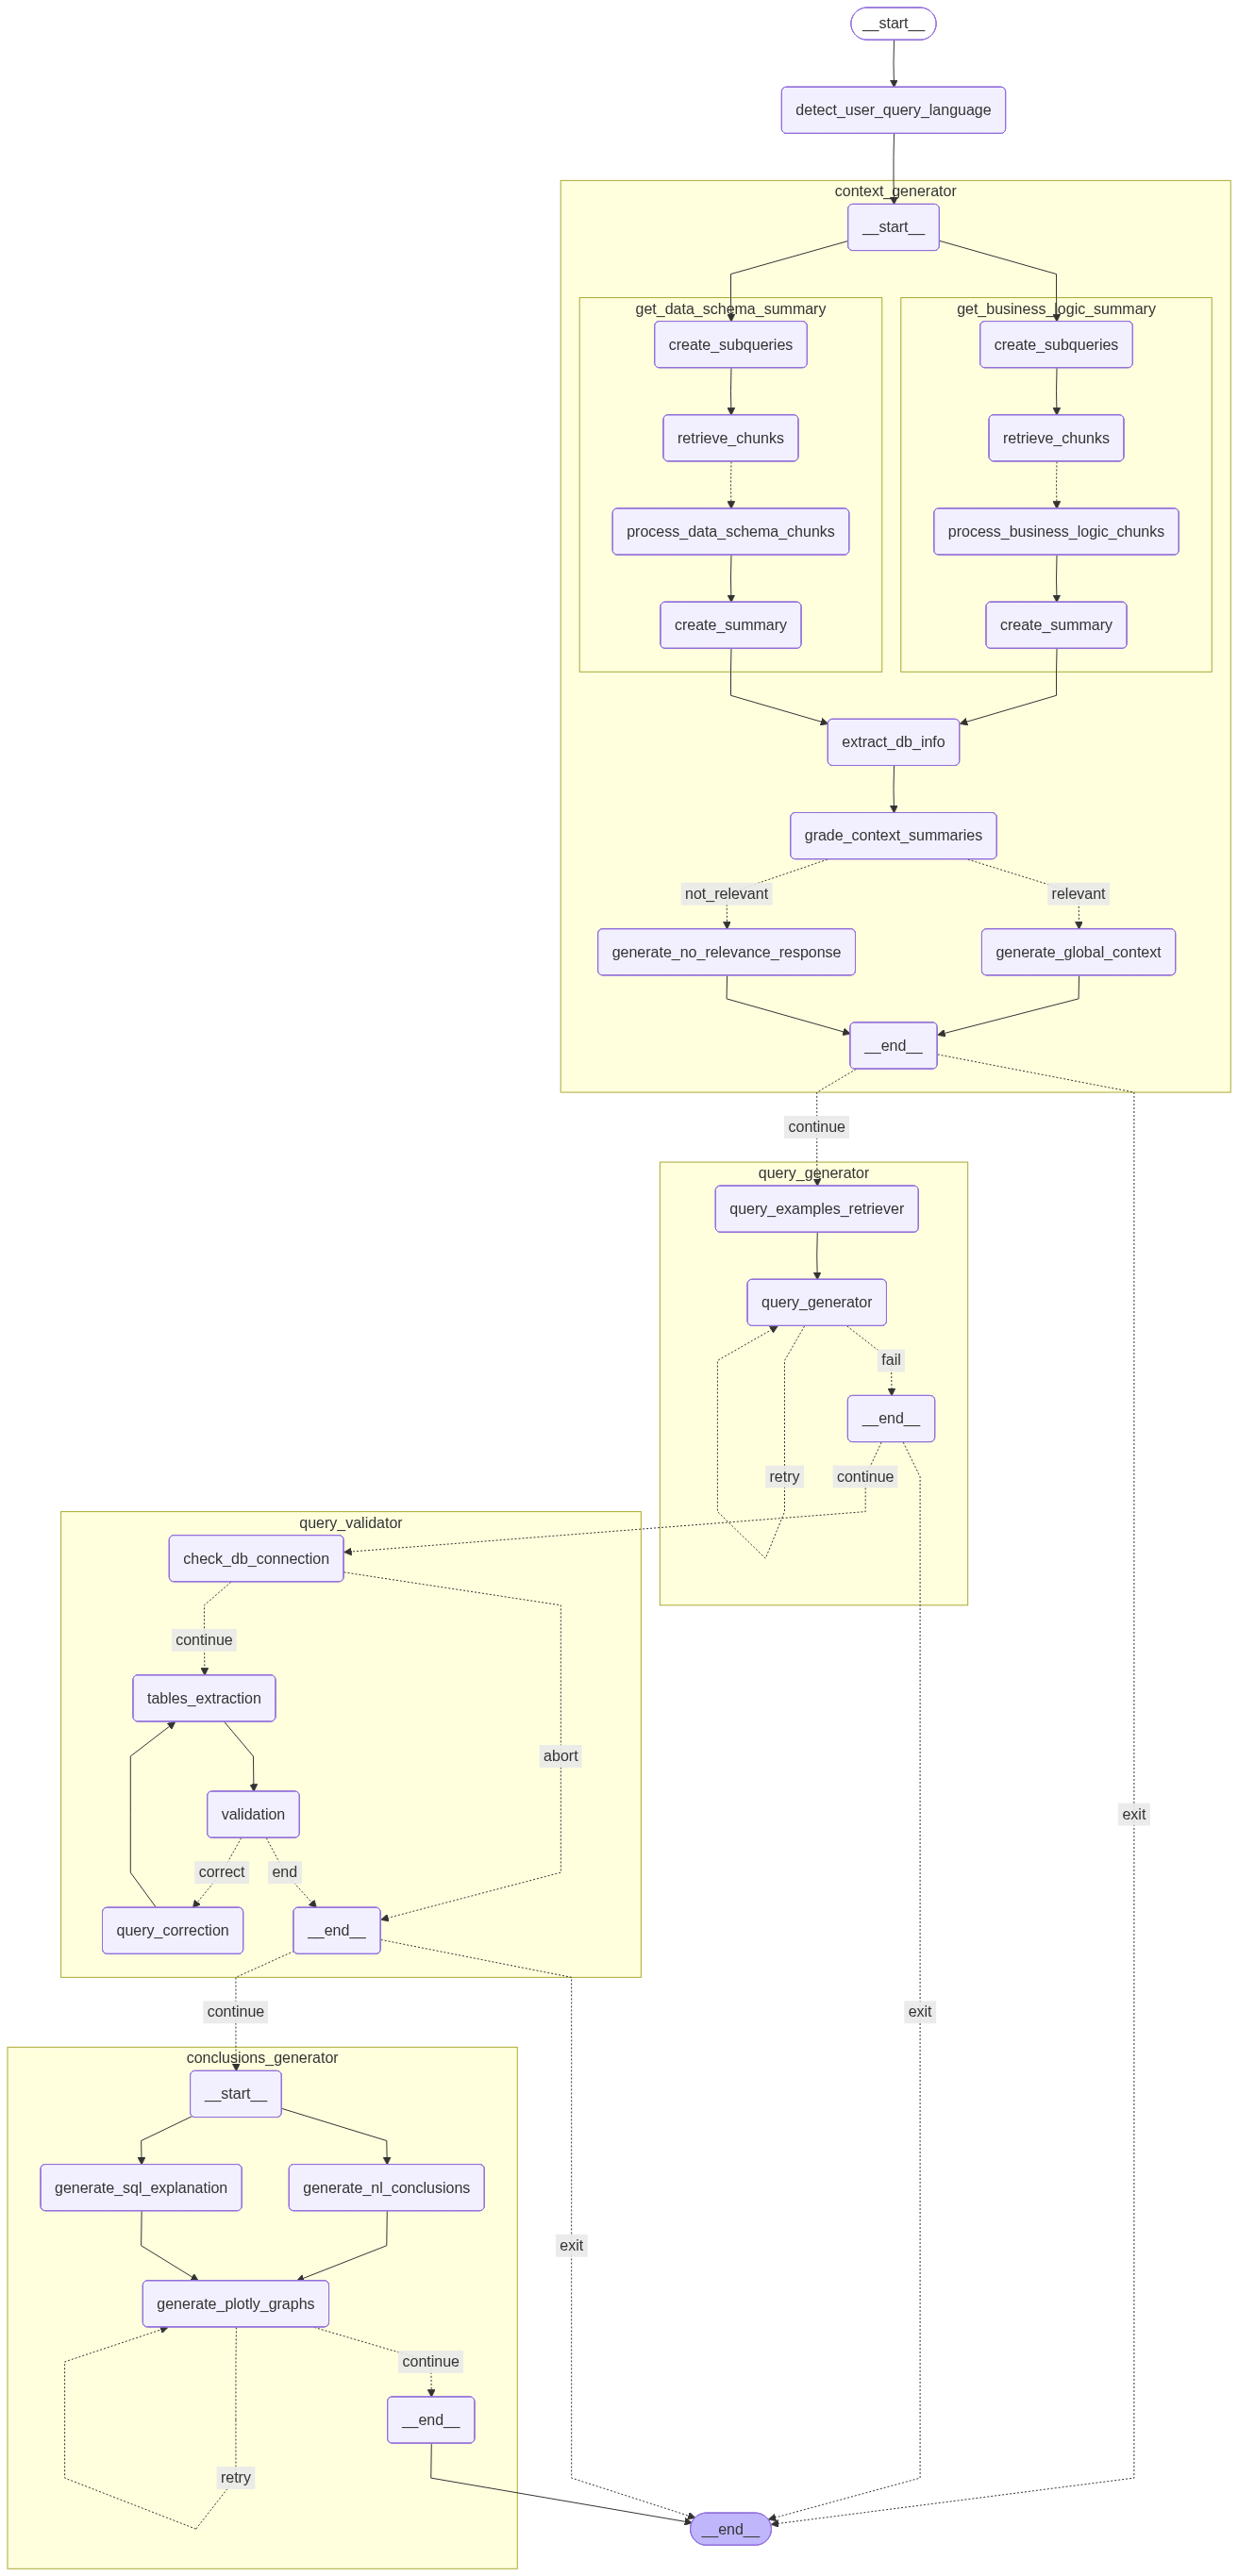

In [10]:
main_graph = get_main_graph()
Image(main_graph.get_graph(xray=2).draw_mermaid_png())

In [3]:
result = main_graph.invoke({
    "user_query": "Muéstrame los 10 productos más vendidos para el B2B en el último trimestre, excluyendo los Accesorios. Mes a mes indica cuántas unidades se vendieron, y muestra también a qué categoría y subcategoría pertenecen",
})

result

--- DEFINE USER QUERY LANGUAGE 🔣 ---
--- GENERATING BUSINESS_LOGIC SUB-QUERIES 📚 ---
--- GENERATING MDL SUB-QUERIES 📚 ---
--- MDL RETRIEVE TOOL 🛠️ ---
--- BUSINESS_LOGIC RETRIEVE TOOL 🛠️ ---
--- PARALLELIZE GENERATION 🔢 ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE: RELEVANT CHUNK ✅ ---
--- SUMMARIZE CHUNK 📝📚 ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT 

No relevant docs were retrieved using the relevance score threshold 0.75


--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---


No relevant docs were retrieved using the relevance score threshold 0.75


--- CHECK ITERATIONS 🔁 ---
--- GRADE HALLUCINATIONS 👻 ---
--- DECISION: GENERATION IS GROUNDED IN DOCUMENTS ✅ ---
--- DECISION: GENERATION ADDRESSES QUESTION ✅ ---
--- CHECK ITERATIONS 🔁 ------ CHECK ITERATIONS 🔁 ---
--- GRADE HALLUCINATIONS 👻 ---

--- GRADE HALLUCINATIONS 👻 ---
--- DECISION: GENERATION IS GROUNDED IN DOCUMENTS ✅ ---
--- DECISION: GENERATION IS GROUNDED IN DOCUMENTS ✅ ---
--- DECISION: GENERATION ADDRESSES QUESTION ✅ ------ DECISION: GENERATION ADDRESSES QUESTION ✅ ---

--- SUMMARIZE BUSINES LOGIC 📝👨‍💼 ---


No relevant docs were retrieved using the relevance score threshold 0.75
No relevant docs were retrieved using the relevance score threshold 0.75
No relevant docs were retrieved using the relevance score threshold 0.75


--- PARALLELIZE GENERATION 🔢 ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: RELEVANT CHUNK ✅ ---
--- SUMMARIZE CHUNK 📝📚 ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRI

{'user_query': 'Muéstrame los 10 productos más vendidos para el B2B en el último trimestre, excluyendo los Accesorios. Mes a mes indica cuántas unidades se vendieron, y muestra también a qué categoría y subcategoría pertenecen',
 'language': 'Spanish',
 'relevant_context': True,
 'context': '### Resumen General\nEl objetivo es identificar los 10 productos más vendidos en el contexto de ventas B2B durante el último trimestre, excluyendo aquellos que pertenecen a la categoría "Accesorios". Además, se requiere desglosar las ventas mes a mes, mostrando la cantidad de unidades vendidas junto con la categoría y subcategoría de cada producto.\n\n### Esquema de Datos y Relaciones\n#### Base de Datos y Esquema\n- **Base de datos:** adventure_works_dw\n- **Esquema:** sales\n\n#### Tabla: fact_sales\n- **Descripción:** Contiene detalles de órdenes de ventas entregadas, con granularidad a nivel de línea.\n- **Columnas relevantes:**\n  - **order_quantity**: INT2, cantidad vendida de cada producto.\

In [4]:
print(result['sql_query'])

WITH 
last_quarter AS (
  SELECT
    fs.product_key,
    COALESCE(dp.spanish_product_name, dp.english_product_name) AS product_name,
    dp.spanish_product_category_name,
    dp.spanish_product_subcategory_name,
    EXTRACT(MONTH FROM fs.order_date) AS month_in_quarter,
    fs.order_quantity
  FROM
    sales.fact_sales fs
    JOIN sales.dim_product dp ON fs.product_key = dp.product_key
  WHERE
    fs.sale_source = 'reseller_sales'
    AND dp.spanish_product_category_name <> 'Accesorio'
    AND fs.order_date >= date_trunc('quarter', CURRENT_DATE - interval '3 months')
    AND fs.order_date < date_trunc('quarter', CURRENT_DATE)
),
top_products AS (
  SELECT
    product_key,
    product_name,
    spanish_product_category_name,
    spanish_product_subcategory_name,
    SUM(order_quantity) AS total_qty
  FROM
    last_quarter
  GROUP BY
    product_key, product_name, spanish_product_category_name, spanish_product_subcategory_name
  ORDER BY
    total_qty DESC
  LIMIT 10
)
SELECT
  tp.produc

In [5]:
print(result['query_results'])

[{'producto': 'Camiseta clásica, P', 'categoria': 'Prenda', 'subcategoria': 'Camiseta', 'primer_mes': 381, 'segundo_mes': 380, 'tercer_mes': 190, 'total': 951}, {'producto': 'Jersey clásico de manga corta, SG', 'categoria': 'Prenda', 'subcategoria': 'Jersey', 'primer_mes': 329, 'segundo_mes': 299, 'tercer_mes': 183, 'total': 811}, {'producto': "Women's Mountain Shorts, S", 'categoria': 'Prenda', 'subcategoria': 'Pantalones cortos', 'primer_mes': 295, 'segundo_mes': 258, 'tercer_mes': 141, 'total': 694}, {'producto': 'Jersey con logotipo de manga larga, G', 'categoria': 'Prenda', 'subcategoria': 'Jersey', 'primer_mes': 312, 'segundo_mes': 243, 'tercer_mes': 129, 'total': 684}, {'producto': 'AWC Logo Cap', 'categoria': 'Prenda', 'subcategoria': 'Gorra', 'primer_mes': 291, 'segundo_mes': 243, 'tercer_mes': 121, 'total': 655}, {'producto': "Women's Mountain Shorts, L", 'categoria': 'Prenda', 'subcategoria': 'Pantalones cortos', 'primer_mes': 262, 'segundo_mes': 236, 'tercer_mes': 120, 'tot

In [6]:
print(result['nl_output'])

1. Las prendas dominan las ventas B2B en el último trimestre, con todas las posiciones en el top 10 perteneciendo a esta categoría.  
2. La subcategoría Camiseta lidera en unidades vendidas, destacando la "Camiseta clásica, P" con 951 unidades totales.  
3. Los Jerseys, tanto de manga corta como larga, tienen una fuerte presencia con tres productos en el ranking.  
4. Los Pantalones cortos también son relevantes, con dos tallas diferentes en el top 10.  
5. La venta mensual muestra una tendencia decreciente en unidades vendidas de primer a tercer mes para todos los productos.  
6. La gorra "AWC Logo Cap" es el único producto fuera de prendas básicas (camisetas, jerseys, pantalones cortos) en el top 10.  
7. Los calcetines y guantes, aunque en menor volumen, mantienen presencia en el ranking, indicando diversidad en la oferta de prendas.  
8. Ningún accesorio aparece en el top 10, cumpliendo la exclusión solicitada.  
9. La suma total de unidades vendidas por producto varía entre 437 y 

In [7]:
print(result['sql_explanation'])

## Análisis de la Lógica de la Consulta

La consulta primero identifica las ventas del último trimestre para el canal B2B (denominado aquí como "reseller_sales"), excluyendo los productos que pertenecen a la categoría "Accesorio". Para ello, une la tabla de ventas con la tabla de productos para obtener el nombre, categoría y subcategoría de cada producto vendido. Luego, agrupa estas ventas por producto para calcular el total de unidades vendidas en ese periodo y selecciona los 10 productos con mayor volumen de ventas. Finalmente, para esos 10 productos, desglosa las unidades vendidas mes a mes dentro del trimestre, mostrando también la categoría y subcategoría a la que pertenecen.

## Conclusión y Resultados Clave

Con esta consulta se obtiene una lista clara de los 10 productos más vendidos en el canal B2B durante el último trimestre, excluyendo accesorios, junto con la cantidad de unidades vendidas en cada uno de los tres meses del trimestre. Además, se muestra la categoría y subcate

In [8]:
create_dashboard_from_json(result['graphics_json'])

---

## QUERY GENERATOR

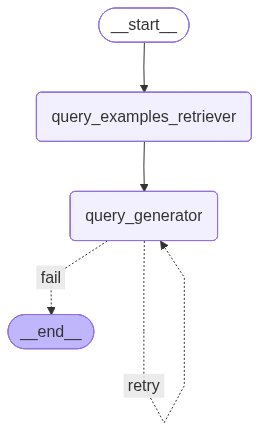

In [7]:
query_generator_graph = get_query_generator_graph()
Image(query_generator_graph.get_graph().draw_mermaid_png())

In [3]:
query_generator_graph.invoke({
    "context": "Tablas:\n  customers(id, name, country)\n",
    "user_query": "Muéstrame los 10 productos más vendidos para el B2B en el último trimestre, excluyendo los Accesorios. Mes a mes indica cuántas unidades se vendieron, y muestra también a qué categoría y subcategoría pertenecen",
    "language": "Spanish"
})

---QUERY EXAMPLES RETRIEVE TOOL---


{'sql_query': "WITH \nlast_quarter AS (\n  SELECT\n    fs.product_key,\n    COALESCE(dp.spanish_product_name, dp.english_product_name) AS product_name,\n    dp.spanish_product_category_name,\n    dp.spanish_product_subcategory_name,\n    EXTRACT(MONTH FROM fs.order_date) AS month_in_quarter,\n    fs.order_quantity\n  FROM\n    sales.fact_sales fs\n    JOIN sales.dim_product dp ON fs.product_key = dp.product_key\n  WHERE\n    fs.sale_source = 'reseller_sales'\n    AND dp.spanish_product_category_name <> 'Accesorio'\n    AND fs.order_date >= date_trunc('quarter', CURRENT_DATE - interval '3 months')\n    AND fs.order_date < date_trunc('quarter', CURRENT_DATE)\n),\ntop_products AS (\n  SELECT\n    product_key,\n    product_name,\n    spanish_product_category_name,\n    spanish_product_subcategory_name,\n    SUM(order_quantity) AS total_qty\n  FROM\n    last_quarter\n  GROUP BY\n    product_key, product_name, spanish_product_category_name, spanish_product_subcategory_name\n  ORDER BY\n    t

---

## Chunk Processing

In [ ]:
chunk_processing_graph = ChunkProcessingGraph()

chunk_processing_graph = chunk_processing_graph.get_compiled_graph()

--- BUILDING CHUNK PROCESSING GRAPH 🏗️ ---
--- CHUNK PROCESSING GRAPH COMPILED SUCCESSFULLY ⚙️✅ ---


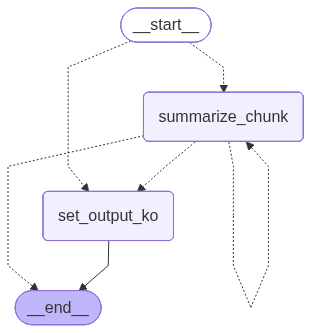

In [3]:
display(Image(chunk_processing_graph.get_graph().draw_mermaid_png()))

In [4]:
doc_txt = """
3. Métricas Clásicas del Retail y su Interpretación

Es crucial entender cómo se miden las diferentes métricas en el contexto de negocio.- Cuando se habla de productos "más vendidos", sin especificar más, generalmente nos referimos a la cantidad de unidades (`order_quantity`) vendidas. También puede ser relevante medir esto por el importe facturado (`sales_amount`) para identificar productos que, aunque se vendan en menor volumen, generan más ingresos. Pero, en este último caso se especificarán términos como "de mayor facturación".
- Cuando se refiere a clientes, tiendas/distribuidores o vendedores que "más compran/venden", esto se mide por el importe facturado (`sales_amount`) o `net sales`. Adicionalmente, se puede considerar la frecuencia de compra (para clientes y distribuidores) o el número de pedidos gestionados (para vendedores) como métricas complementarias.
- Para el análisis de rentabilidad, la métrica clave es el margen bruto (`gross margin`) o el porcentaje de margen bruto (`gross margin percentage`), lo cual permite comprender la contribución real de cada venta o producto a las ganancias, más allá del volumen o ingreso total. Este enfoque es vital para evaluar la eficiencia operativa.
- En el contexto de la gestión de promociones, el éxito no solo se mide por el discount_amount o average_discount_rate, sino también por el incremento en `order_quantity` o `sales_amount` directamente atribuible a la promoción. Es fundamental analizar la rentabilidad general del período promocional para determinar su efectividad.
- Ventas B2C (Business-to-Consumer): Estas ventas se refieren a transacciones directas con el consumidor final. En el modelo, corresponden a los pedidos donde `sale_source` es igual a `'internet_sales'`. Puede identificarse también como la unidad de negocio encargada del comercio minorista.
- Ventas B2B (Business-to-Business): Estas ventas se refieren a transacciones entre empresas, como las realizadas con distribuidores o tiendas minoristas. En el modelo, corresponden a los pedidos donde `sale_source` es igual a `'reseller_sales'`. Puede identificarse también como la unidad de negocio encargada del comercio mayorista.
"""

user_query = 'The name of the product most selled.'

test_chunk = chunk_processing_graph.invoke({
    "user_query": user_query,
    "language": 'English',
    "entity": 'business_logic',
    "chunk_txt": doc_txt, 
})

test_chunk

--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE: RELEVANT CHUNK ✅ ---
--- SUMMARIZE CHUNK 📝📚 ---
--- CHECK ITERATIONS 🔁 ---
--- GRADE HALLUCINATIONS 👻 ---
--- DECISION: GENERATION IS GROUNDED IN DOCUMENTS ✅ ---
--- DECISION: GENERATION ADDRESSES QUESTION ✅ ---


{'chunk_summary': ['Synthesized Business Logic\n\n### High-Level Summary\nThe context provides business rules and metrics related to retail sales, including definitions and interpretations of "most sold products" and other related metrics. It specifies how to measure and interpret sales data, including unit sales, revenue, and profitability.\n\n### Detailed Breakdown\n\n#### Definition of "Most Sold Products"\n- The term "most sold products" generally refers to the quantity of units sold (`order_quantity`).\n- Alternatively, it can be measured by the revenue generated (`sales_amount`), which identifies products that generate higher income despite lower sales volume. This is explicitly referred to as "products with the highest revenue" or "de mayor facturación".\n\n#### Related Metrics and Interpretations\n- **Sales Metrics:**\n  - `order_quantity`: Represents the number of units sold.\n  - `sales_amount`: Represents the total revenue generated from sales.\n- **Profitability Metrics:**\

---

## Business Logic

In [ ]:
business_logic_graph = BusinessLogicRetrievalGraph()

business_logic_graph = business_logic_graph.get_compiled_graph()

--- BUILDING BUSINESSLOGICRETRIEVALGRAPH GRAPH 🏗️ ---
--- BUILDING CHUNK PROCESSING GRAPH 🏗️ ---
--- CHUNK PROCESSING GRAPH COMPILED SUCCESSFULLY ⚙️✅ ---
--- BUSINESSLOGICRETRIEVALGRAPH COMPILED SUCCESSFULLY ✅ ---


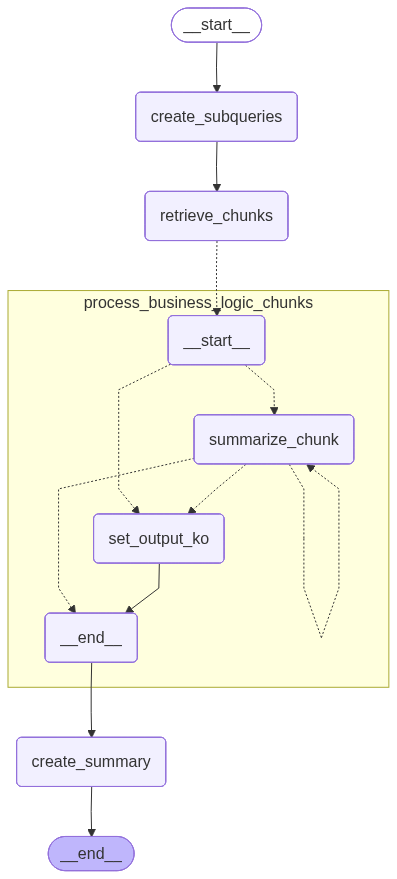

In [6]:
display(Image(business_logic_graph.get_graph(xray=1).draw_mermaid_png()))

In [7]:
user_query = 'Dime las ventas del último trimestre detallas por categorías de producto.'

business_logic_test = business_logic_graph.invoke({
    "user_query": user_query,
    'language': 'Spanish'
})['business_logic']

Markdown(business_logic_test)

--- GENERATING BUSINESS_LOGIC SUB-QUERIES 📚 ---
--- BUSINESS_LOGIC RETRIEVE TOOL 🛠️ ---
--- PARALLELIZE GENERATION 🔢 ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE: RELEVANT CHUNK ✅ ---
--- SUMMARIZE CHUNK 📝📚 ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GR

### Lógica de Negocio Sintetizada

#### Resumen de Alto Nivel
El contexto proporciona reglas y ejemplos específicos para calcular las ventas del último trimestre y desglosarlas por categorías de producto. Se incluyen definiciones de períodos trimestrales, herramientas SQL para manipulación de fechas, y ejemplos de consultas SQL relevantes.

#### Detalles Específicos

1. **Definición de Trimestre**:
   - Un trimestre es un período de tres meses.
   - Los trimestres en un año natural son:
     - Q1: Enero-Marzo
     - Q2: Abril-Junio
     - Q3: Julio-Septiembre
     - Q4: Octubre-Diciembre.

2. **Uso del Campo `order_date`**:
   - Todas las consultas relacionadas con períodos temporales deben utilizar el campo `order_date` de la tabla `fact_sales`.

3. **Consultas SQL Relevantes**:
   - **Ventas del Trimestre Pasado**:
     ```sql
     SELECT product_key, SUM(sales_amount) AS total_sales
     FROM sales.fact_sales
     WHERE order_date BETWEEN DATE_TRUNC('quarter', CURRENT_DATE - INTERVAL '3 months') AND DATE_TRUNC('quarter', CURRENT_DATE) - INTERVAL '1 day'
     GROUP BY product_key;
     ```
   - Esta consulta calcula las ventas del trimestre anterior y las desglosa por categorías de producto (`product_key`).

4. **Herramientas SQL para Manipulación de Fechas**:
   - `DATE_TRUNC('quarter', date)` para truncar fechas al inicio del trimestre.
   - `INTERVAL` para operaciones de tiempo.

#### Observaciones
El contexto incluye toda la información necesaria para calcular las ventas del último trimestre y desglosarlas por categorías de producto, utilizando el campo `order_date` y agrupando por `product_key`.

---

## MDL

In [8]:
mdl_graph = MdlRetrievalGraph()

mdl_graph = mdl_graph.get_compiled_graph()

--- BUILDING MDLRETRIEVALGRAPH GRAPH 🏗️ ---
--- BUILDING CHUNK PROCESSING GRAPH 🏗️ ---
--- CHUNK PROCESSING GRAPH COMPILED SUCCESSFULLY ⚙️✅ ---
--- MDLRETRIEVALGRAPH COMPILED SUCCESSFULLY ✅ ---


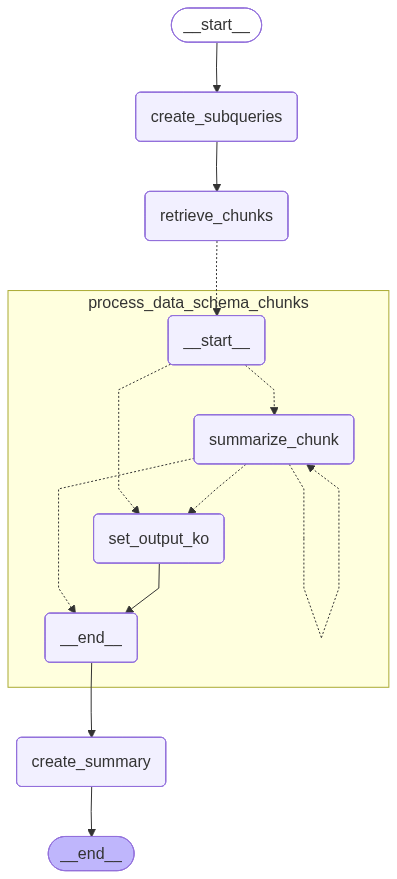

In [9]:
display(Image(mdl_graph.get_graph(xray=1).draw_mermaid_png()))

In [10]:
user_query = 'Dime las ventas del último trimestre detallas por categorías de producto.'

mdl_test = mdl_graph.invoke({
    "user_query": user_query,
    'language': 'Spanish'
})['data_schema']

Markdown(mdl_test)

--- GENERATING MDL SUB-QUERIES 📚 ---
--- MDL RETRIEVE TOOL 🛠️ ---


No relevant docs were retrieved using the relevance score threshold 0.75
No relevant docs were retrieved using the relevance score threshold 0.75
No relevant docs were retrieved using the relevance score threshold 0.75
No relevant docs were retrieved using the relevance score threshold 0.75
No relevant docs were retrieved using the relevance score threshold 0.75


--- PARALLELIZE GENERATION 🔢 ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ------ GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---

--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: RELEVANT CHUNK ✅ ---
--- SUMMARIZE CHUNK 📝📚 ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: RELEVANT CHUNK ✅ ---
--- SUMMARIZE CHUN

### Información detallada de tablas y columnas relevantes

#### Base de datos y esquema
- **Base de datos:** adventure_works_dw
- **Esquema:** sales

#### Tabla: dim_product
- **Descripción:** Contiene información detallada de cada producto vendido.
- **Clave primaria:** product_key
- **Columnas relevantes:**
  - **spanish_product_category_name** (VARCHAR(50)): Categoría principal del producto en español. Nunca NULL.
  - **spanish_product_subcategory_name** (VARCHAR(50)): Subcategoría del producto en español. Nunca NULL.
  - **spanish_product_name** (VARCHAR(50)): Nombre del producto en español. Puede ser NULL.
  - **list_price** (NUMERIC): Precio de venta del producto en USD.
  - **start_date** (DATE): Fecha de disponibilidad del producto para la venta.
  - **end_date** (DATE): Fecha de fin de disponibilidad del producto. Puede ser NULL.
  - **active** (BOOL): Indicador de disponibilidad actual del producto.

#### Tabla: fact_sales
- **Descripción:** Contiene detalles de órdenes de ventas entregadas, con granularidad a nivel de línea.
- **Clave primaria:**
  - sales_order_number
  - sales_order_line_number
- **Claves foráneas:**
  - product_key → sales.dim_product.product_key
- **Columnas relevantes:**
  - **order_quantity** (INT2): Cantidad vendida de cada producto.
  - **sales_amount** (NUMERIC): Subtotal en USD de la línea de orden de venta.
  - **order_date** (DATE): Fecha de creación del pedido.
  - **product_key**: Relaciona con `sales.dim_product`.

### Relación entre tablas
- La tabla `fact_sales` se relaciona con `dim_product` mediante la clave foránea `product_key`.
- Condición de unión: `fact_sales.product_key = dim_product.product_key`.

### Condiciones para el cálculo del último trimestre
- Filtrar las ventas en `fact_sales` utilizando la columna `order_date` para el último trimestre.
- Relacionar con `dim_product` para obtener las categorías de producto mediante `spanish_product_category_name`.

---

## GLOBAL

In [2]:
context_generator_graph = ContextGeneratorGraph()

context_generator_graph = context_generator_graph.get_compiled_graph()

--- BUILDING CONTEXT GENERATOR GRAPH 🏗️ ---
--- BUILDING BUSINESSLOGICRETRIEVALGRAPH GRAPH 🏗️ ---
--- BUILDING CHUNK PROCESSING GRAPH 🏗️ ---
--- CHUNK PROCESSING GRAPH COMPILED SUCCESSFULLY ⚙️✅ ---
--- BUSINESSLOGICRETRIEVALGRAPH COMPILED SUCCESSFULLY ✅ ---
--- BUILDING MDLRETRIEVALGRAPH GRAPH 🏗️ ---
--- BUILDING CHUNK PROCESSING GRAPH 🏗️ ---
--- CHUNK PROCESSING GRAPH COMPILED SUCCESSFULLY ⚙️✅ ---
--- MDLRETRIEVALGRAPH COMPILED SUCCESSFULLY ✅ ---
--- CONTEXT GENERATOR COMPILED SUCCESSFULLY ✅ ---


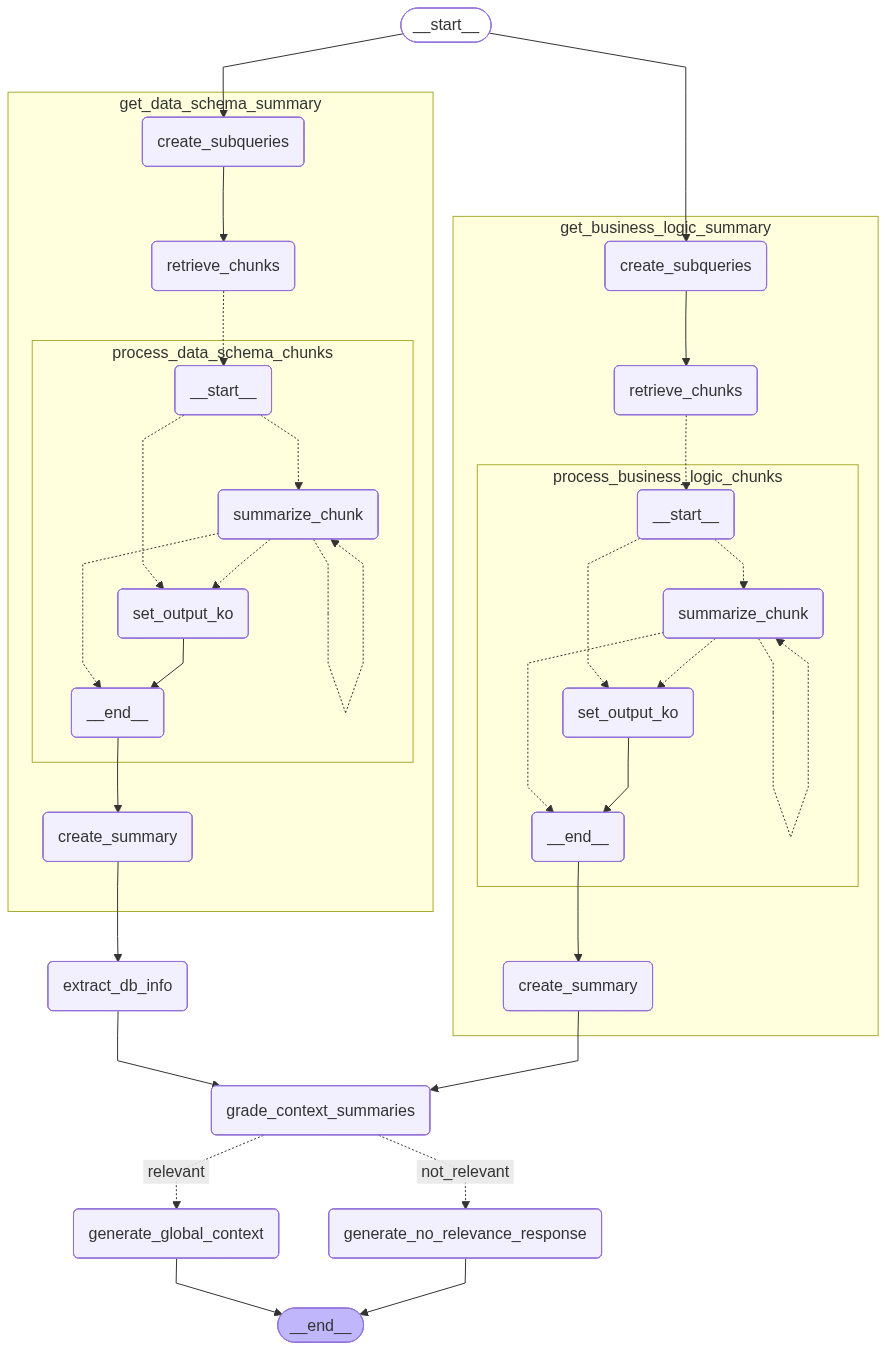

In [3]:
display(Image(context_generator_graph.get_graph(xray=3).draw_mermaid_png()))

In [4]:
user_query = 'Dime las ventas del último trimestre detallas por categorías de producto.'

global_context_test = context_generator_graph.invoke({
    "user_query": user_query
})

global_context_test

--- DEFINE USER QUERY LANGUAGE 🔣 ---
--- GENERATING BUSINESS_LOGIC SUB-QUERIES 📚 ---
--- GENERATING MDL SUB-QUERIES 📚 ---
--- MDL RETRIEVE TOOL 🛠️ ---
--- BUSINESS_LOGIC RETRIEVE TOOL 🛠️ ---


No relevant docs were retrieved using the relevance score threshold 0.75


--- PARALLELIZE GENERATION 🔢 ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE: RELEVANT CHUNK ✅ ---
--- SUMMARIZE CHUNK 📝📚 ---
--- GRADE: RELEVANT CHUNK ✅ ---
--- SUMMARIZE CHUNK 📝📚 ---
--- GRADE: RELEVANT CHUNK ✅ ---
--- SUMMARIZE CHUNK 📝📚 ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVA

No relevant docs were retrieved using the relevance score threshold 0.75


--- CHECK ITERATIONS 🔁 ---
--- GRADE HALLUCINATIONS 👻 ---
--- CHECK ITERATIONS 🔁 ---
--- GRADE HALLUCINATIONS 👻 ---
--- DECISION: GENERATION IS GROUNDED IN DOCUMENTS ✅ ---
--- DECISION: GENERATION IS GROUNDED IN DOCUMENTS ✅ ---
--- CHECK ITERATIONS 🔁 ---
--- GRADE HALLUCINATIONS 👻 ---
--- DECISION: GENERATION ADDRESSES QUESTION ✅ ---
--- DECISION: GENERATION ADDRESSES QUESTION ✅ ---
--- DECISION: GENERATION IS GROUNDED IN DOCUMENTS ✅ ---
--- DECISION: GENERATION ADDRESSES QUESTION ✅ ---


No relevant docs were retrieved using the relevance score threshold 0.75


--- CHECK ITERATIONS 🔁 ---
--- GRADE HALLUCINATIONS 👻 ---
--- DECISION: GENERATION IS GROUNDED IN DOCUMENTS ✅ ---


No relevant docs were retrieved using the relevance score threshold 0.75


--- DECISION: GENERATION ADDRESSES QUESTION ✅ ---
--- CHECK ITERATIONS 🔁 ---
--- GRADE HALLUCINATIONS 👻 ---
--- CHECK ITERATIONS 🔁 ---
--- GRADE HALLUCINATIONS 👻 ---
--- DECISION: GENERATION IS GROUNDED IN DOCUMENTS ✅ ---
--- DECISION: GENERATION IS GROUNDED IN DOCUMENTS ✅ ---
--- DECISION: GENERATION ADDRESSES QUESTION ✅ ---
--- DECISION: GENERATION ADDRESSES QUESTION ✅ ---
--- CHECK ITERATIONS 🔁 ---
--- GRADE HALLUCINATIONS 👻 ---
--- DECISION: GENERATION IS GROUNDED IN DOCUMENTS ✅ ---
--- DECISION: GENERATION ADDRESSES QUESTION ✅ ---
--- SUMMARIZE BUSINES LOGIC 📝👨‍💼 ---


No relevant docs were retrieved using the relevance score threshold 0.75


--- PARALLELIZE GENERATION 🔢 ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: RELEVANT CHUNK ✅ ---
--- SUMMARIZE CHUNK 📝📚 ---
--- GRADE: RELEVANT CHUNK ✅ ---
--- SUMMARIZE CHUNK 📝📚 ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT 

{'language': 'Spanish',
 'relevant_context': True,
 'context': "### Resumen General\nEl objetivo es calcular las ventas del último trimestre, desglosadas por categorías de producto. Esto implica utilizar datos de ventas y productos, aplicando filtros temporales y uniendo tablas relevantes para obtener las categorías de producto y sus ventas asociadas.\n\n### Esquema Detallado y Relaciones\n#### Base de datos y esquema\n- **Base de datos:** adventure_works_dw\n- **Esquema:** sales\n\n#### Tabla: dim_product\n- **Descripción:** Contiene información detallada de productos, incluyendo categorías y precios.\n- **Clave primaria:** product_key\n- **Columnas relevantes:**\n  - **spanish_product_category_name** (VARCHAR(50), NOT NULL): Categoría principal del producto en español.\n  - **spanish_product_subcategory_name** (VARCHAR(50), NOT NULL): Subcategoría del producto en español.\n  - **spanish_product_name** (VARCHAR(50), NULL): Nombre del producto en español.\n  - **list_price** (NUMERIC):

In [5]:
Markdown(global_context_test['context'])

### Resumen General
El objetivo es calcular las ventas del último trimestre, desglosadas por categorías de producto. Esto implica utilizar datos de ventas y productos, aplicando filtros temporales y uniendo tablas relevantes para obtener las categorías de producto y sus ventas asociadas.

### Esquema Detallado y Relaciones
#### Base de datos y esquema
- **Base de datos:** adventure_works_dw
- **Esquema:** sales

#### Tabla: dim_product
- **Descripción:** Contiene información detallada de productos, incluyendo categorías y precios.
- **Clave primaria:** product_key
- **Columnas relevantes:**
  - **spanish_product_category_name** (VARCHAR(50), NOT NULL): Categoría principal del producto en español.
  - **spanish_product_subcategory_name** (VARCHAR(50), NOT NULL): Subcategoría del producto en español.
  - **spanish_product_name** (VARCHAR(50), NULL): Nombre del producto en español.
  - **list_price** (NUMERIC): Precio de venta del producto en USD.
  - **start_date** (DATE): Fecha de disponibilidad del producto para la venta.
  - **end_date** (DATE, NULL): Fecha de fin de disponibilidad del producto.

#### Tabla: fact_sales
- **Descripción:** Contiene detalles de órdenes de ventas con granularidad a nivel de línea.
- **Clave primaria:**
  - sales_order_number
  - sales_order_line_number
- **Claves foráneas:**
  - product_key → sales.dim_product.product_key
- **Columnas relevantes:**
  - **order_date** (DATE): Fecha de creación del pedido.
  - **sales_amount** (NUMERIC): Subtotal en USD de la línea de orden de venta.
  - **order_quantity** (INT2): Cantidad vendida de cada producto.
  - **product_key**: Referencia a la tabla `sales.dim_product`.

#### Relaciones entre tablas
- Para obtener las categorías de producto y sus ventas, se debe realizar un JOIN entre `fact_sales` y `dim_product` utilizando la clave foránea `product_key`:
  ```sql
  ON fact_sales.product_key = dim_product.product_key
  ```
- Para filtrar las ventas del último trimestre, se debe aplicar un filtro en la columna `order_date` con el rango de fechas correspondiente.

### Reglas de Negocio y Lógica
1. **Definición de Trimestre:**
   - Un trimestre es un período de tres meses.
   - Los trimestres en un año natural son:
     - Q1: Enero a Marzo.
     - Q2: Abril a Junio.
     - Q3: Julio a Septiembre.
     - Q4: Octubre a Diciembre.

2. **Filtro Temporal:**
   - Para calcular las ventas del último trimestre, se utiliza el campo `order_date` de la tabla `fact_sales` con el siguiente rango de fechas:
     ```sql
     WHERE order_date BETWEEN DATE_TRUNC('quarter', CURRENT_DATE - INTERVAL '3 months') AND DATE_TRUNC('quarter', CURRENT_DATE) - INTERVAL '1 day'
     ```

3. **Cálculo de Ventas:**
   - Las ventas totales se calculan sumando el campo `sales_amount`.

4. **Representación de Categorías de Producto:**
   - Se prioriza el uso del campo `spanish_product_category_name` de la tabla `dim_product`. Si este es nulo, se puede usar un campo alternativo como `english_product_category_name`.

5. **Consulta SQL Representativa:**
   - Una consulta representativa para obtener las ventas del último trimestre desglosadas por categorías de producto sería:
     ```sql
     SELECT 
         COALESCE(spanish_product_category_name, 'Categoría no registrada') AS categoria_producto,
         SUM(sales_amount) AS ventas_totales
     FROM 
         sales.fact_sales
     JOIN 
         sales.dim_product
     ON 
         fact_sales.product_key = dim_product.product_key
     WHERE 
         order_date BETWEEN DATE_TRUNC('quarter', CURRENT_DATE - INTERVAL '3 months') AND DATE_TRUNC('quarter', CURRENT_DATE) - INTERVAL '1 day'
     GROUP BY 
         spanish_product_category_name;
     ```

In [6]:
user_query = 'Dime los 10 clientes que más han comprado el mes pasado.'

global_context_test = context_generator_graph.invoke({
    "user_query": user_query
})

global_context_test

--- DEFINE USER QUERY LANGUAGE 🔣 ---
--- GENERATING BUSINESS_LOGIC SUB-QUERIES 📚 ---
--- GENERATING MDL SUB-QUERIES 📚 ---
--- MDL RETRIEVE TOOL 🛠️ ---
--- BUSINESS_LOGIC RETRIEVE TOOL 🛠️ ---


No relevant docs were retrieved using the relevance score threshold 0.75


--- PARALLELIZE GENERATION 🔢 ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE: RELEVANT CHUNK ✅ ---
--- SUMMARIZE CHUNK 📝📚 ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRI

No relevant docs were retrieved using the relevance score threshold 0.75


--- CHECK ITERATIONS 🔁 ---
--- GRADE HALLUCINATIONS 👻 ---
--- DECISION: GENERATION IS GROUNDED IN DOCUMENTS ✅ ---


No relevant docs were retrieved using the relevance score threshold 0.75


--- DECISION: GENERATION ADDRESSES QUESTION ✅ ---
--- CHECK ITERATIONS 🔁 ---
--- GRADE HALLUCINATIONS 👻 ---
--- CHECK ITERATIONS 🔁 ---
--- GRADE HALLUCINATIONS 👻 ---
--- DECISION: GENERATION IS NOT GROUNDED (HALLUCINATIONS) 👻❌ ---
--- SUMMARIZE CHUNK 📝📚 ---
--- DECISION: GENERATION IS GROUNDED IN DOCUMENTS ✅ ---
--- CHECK ITERATIONS 🔁 ---
--- GRADE HALLUCINATIONS 👻 ---


No relevant docs were retrieved using the relevance score threshold 0.75


--- DECISION: GENERATION ADDRESSES QUESTION ✅ ---
--- DECISION: GENERATION IS GROUNDED IN DOCUMENTS ✅ ---
--- DECISION: GENERATION ADDRESSES QUESTION ✅ ---


No relevant docs were retrieved using the relevance score threshold 0.75


--- PARALLELIZE GENERATION 🔢 ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE: RELEVANT CHUNK ✅ ---
--- SUMMARIZE CHUNK 📝📚 ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRI

{'language': 'Spanish',
 'relevant_context': True,
 'context': "### Resumen General\nEl objetivo es identificar los 10 clientes que más han comprado durante el mes pasado, considerando únicamente las ventas realizadas en línea (B2C). Esto implica calcular el volumen total de ventas por cliente, filtrando las transacciones por el mes anterior y ordenando los resultados en orden descendente según el importe total de ventas.\n\n### Esquema Detallado y Relaciones\n#### Base de datos y esquema\n- **Base de datos:** adventure_works_dw\n- **Esquema:** sales\n\n#### Tabla: dim_customer\n- **Descripción:** Contiene información detallada de clientes que han realizado compras en línea en el segmento minorista (B2C).\n- **Clave primaria:** customer_key\n- **Columnas relevantes:**\n  1. **customer_full_name**: Tipo de dato: TEXT, Descripción: Nombre/s y apellido/s del cliente.\n\n#### Tabla: fact_sales\n- **Descripción:** Contiene el detalle de las órdenes de ventas entregadas, con granularidad a n

In [7]:
Markdown(global_context_test['context'])

### Resumen General
El objetivo es identificar los 10 clientes que más han comprado durante el mes pasado, considerando únicamente las ventas realizadas en línea (B2C). Esto implica calcular el volumen total de ventas por cliente, filtrando las transacciones por el mes anterior y ordenando los resultados en orden descendente según el importe total de ventas.

### Esquema Detallado y Relaciones
#### Base de datos y esquema
- **Base de datos:** adventure_works_dw
- **Esquema:** sales

#### Tabla: dim_customer
- **Descripción:** Contiene información detallada de clientes que han realizado compras en línea en el segmento minorista (B2C).
- **Clave primaria:** customer_key
- **Columnas relevantes:**
  1. **customer_full_name**: Tipo de dato: TEXT, Descripción: Nombre/s y apellido/s del cliente.

#### Tabla: fact_sales
- **Descripción:** Contiene el detalle de las órdenes de ventas entregadas, con granularidad a nivel de línea.
- **Clave primaria:** sales_order_number, sales_order_line_number
- **Claves foráneas:** customer_key (referencia a sales.dim_customer.customer_key)
- **Columnas relevantes:**
  1. **order_date**: Tipo de dato: DATE, Descripción: Fecha en la que el pedido fue creado.
  2. **sales_amount**: Tipo de dato: NUMERIC, Descripción: Subtotal en USD de la línea de orden de venta.
  3. **customer_key**: Tipo de dato: Referencia a sales.dim_customer.customer_key, Descripción: Identificador del cliente asociado a la orden de venta.

#### Relaciones entre tablas
- La tabla `fact_sales` se relaciona con la tabla `dim_customer` mediante la clave foránea `customer_key`.
- Para calcular el total de compras por cliente: Usar la columna `sales_amount` y agrupar por `customer_key`.
- Para filtrar las ventas del mes pasado: Usar la columna `order_date` con una condición de rango de fechas.

### Reglas de Negocio y Lógica
1. **Cálculo del Volumen de Ventas por Cliente:**
   - El volumen de ventas por cliente se define como la suma del campo `sales_amount` agrupado por la clave del cliente (`customer_key`).
   - Ejemplo de cálculo:
     ```sql
     SELECT
         fs.customer_key,
         dc.customer_full_name AS cliente,
         SUM(fs.sales_amount) AS importe_ventas_por_cliente
     FROM sales.fact_sales fs
     JOIN sales.dim_customer dc ON fs.customer_key = dc.customer_key
     WHERE fs.sale_source = 'internet_sales'
     GROUP BY fs.customer_key, dc.customer_full_name
     ORDER BY importe_ventas_por_cliente DESC;
     ```

2. **Filtro Temporal para el Mes Pasado:**
   - Para limitar las ventas al mes anterior, se debe incluir una condición en la cláusula `WHERE` que utilice la columna `order_date`. Ejemplo de filtro temporal:
     ```sql
     WHERE fs.order_date >= DATEADD(MONTH, -1, DATEFROMPARTS(YEAR(GETDATE()), MONTH(GETDATE()), 1))
       AND fs.order_date < DATEFROMPARTS(YEAR(GETDATE()), MONTH(GETDATE()), 1)
     ```

3. **Orden y Límite:**
   - Los resultados deben ordenarse en orden descendente según el importe total de ventas (`importe_ventas_por_cliente`).
   - Se deben limitar los resultados a los 10 primeros clientes utilizando `TOP 10` o `LIMIT 10` dependiendo del sistema SQL.

In [8]:
user_query = 'Dime el departamento con el salario medio más alto.'

global_context_test = context_generator_graph.invoke({
    "user_query": user_query
})

global_context_test

--- DEFINE USER QUERY LANGUAGE 🔣 ---
--- GENERATING BUSINESS_LOGIC SUB-QUERIES 📚 ---
--- GENERATING MDL SUB-QUERIES 📚 ---
--- MDL RETRIEVE TOOL 🛠️ ---
--- BUSINESS_LOGIC RETRIEVE TOOL 🛠️ ---
--- PARALLELIZE GENERATION 🔢 ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUN

No relevant docs were retrieved using the relevance score threshold 0.75
No relevant docs were retrieved using the relevance score threshold 0.75
No relevant docs were retrieved using the relevance score threshold 0.75
No relevant docs were retrieved using the relevance score threshold 0.75
No relevant docs were retrieved using the relevance score threshold 0.75


--- PARALLELIZE GENERATION 🔢 ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE CHUNK RELEVANCE TO QUESTION ❔ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️ ---
--- SET RETRIEVAL GRADE OUTPUT KO ❌ ---
--- GRADE: NOT RELEVANT CHUNK 🗑️

{'language': 'Spanish',
 'relevant_context': False,
 'no_relevant_context_msg': 'Lo siento mucho, pero no puedo responder a tu pregunta sobre el departamento con el salario medio más alto, ya que este tema está fuera del alcance de la información proporcionada. Sin embargo, puedo ayudarte con temas relacionados con el análisis de ventas, como el cálculo del volumen de ventas por agente comercial o el valor promedio por orden. Por favor, dime cómo puedo asistirte.'}

In [9]:
Markdown(global_context_test['no_relevant_context_msg'])

Lo siento mucho, pero no puedo responder a tu pregunta sobre el departamento con el salario medio más alto, ya que este tema está fuera del alcance de la información proporcionada. Sin embargo, puedo ayudarte con temas relacionados con el análisis de ventas, como el cálculo del volumen de ventas por agente comercial o el valor promedio por orden. Por favor, dime cómo puedo asistirte.